In [1]:
import pypsa 
import atlite 
import vresutils.shapes as vshapes
from vresutils.graph import voronoi_partition_pts
import geopandas as gpd
import powerplantmatching as pm
import pandas as pd
from scipy.spatial import KDTree
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp, scipy.sparse
from atlite.gis import spdiag, compute_indicatormatrix
import xarray as xr

In [12]:
atlite.Cutout.prepare??

# Build

In [2]:
n = pypsa.Network('original-model_original-data')
#tranfer loads 
loads = n.loads_t.p_set.fillna(0).copy()
n.set_snapshots(pd.DatetimeIndex(start='2015', end='2017', closed='left', freq='h'))
n.loads_t.p_set = (pd.concat([loads.rename(index = lambda ds : ds - pd.Timedelta(270 - i * 52,'W'))
                                 for i in [0,1,2]])
                              [lambda df : ~df.index.duplicated()].reindex(n.snapshots))

INFO:pypsa.io:Imported network original-model_original-data has buses, carriers, generators, lines, loads


In [3]:
#drop generators
n.mremove('Generator', n.generators.index)
n.buses['substation_lv'] = True # assume all buses are substations

In [4]:
#add generators from pm 
pm.config.set_target_countries('Vietnam')
ppl = pm.data.WRI(filter_other_dbs=False) #could also match with pm.data.CARMA()
ppl.Fueltype.replace({'Natural Gas': 'OCGT', 'Hydro':'ror'}, inplace=True, regex=True)
pm.export.to_pypsa_network(ppl, n)
n.generators = n.generators.assign(p_nom_min = n.generators.p_nom)
#add artificial solar and wind
for carrier in ['wind', 'solar', 'ror']:
    not_included = ((n.buses.index).difference(
                        n.generators[n.generators.carrier == carrier].set_index('bus').index) )
    n.madd('Generator', names = not_included + ' ' + carrier,
                        bus = not_included, carrier=carrier)

In [5]:
vietshape = vshapes.countries(subset=['VN'])['VN']
onshore_locs = n.buses.loc[:, ["x", "y"]]
regions = gpd.GeoDataFrame({
        'geometry': voronoi_partition_pts(onshore_locs.values, vietshape),
        'country': 'VN'}, index=onshore_locs.index).rename_axis('bus')

Serving call to countries from file vresutils.shapes.countries_ver3__subset.VN.pickle of cache: 1.3 msec


In [6]:
cutout = atlite.Cutout("vietnam-2015-2016-era5", 
                       module='era5', 
                       bounds=[101,8, 110, 24],
                       years=slice(2015,2016, None))

meta = ( cutout.meta.drop(['height', 'time', 'year-month', 'lat', 'lon'])
                 .to_dataframe().reset_index() )

INFO:atlite.cutout:Assuming a view into the prepared cutout: <Cutout vietnam-2015-2016-era5 x=101.10-109.80 y=23.10-8.10 time=2015/1-2016/12 prepared>


In [7]:
cells = gpd.GeoDataFrame({'geometry' : cutout.grid_cells()})
cells.crs = {'init': u'epsg:4326'}
cells['Area'] = cells.geometry.to_crs({'init': 'epsg:3395'}).map(lambda p: p.area / 10**6)

def custom_layout(meta, cap_per_sq_km):
    return meta.assign(caps = cells.Area * cap_per_sq_km).set_index(['x','y']) \
                .fillna(0).to_xarray().transpose().caps

In [38]:
method = {'wind':'wind', 
          'solar':'pv', 
          'ror':'runoff'}

hydro_capacities = n.generators.groupby(['carrier','bus']).p_nom.sum()['ror']
resource = {'wind' : {'turbine': 'Vestas_V112_3MW',
                         'layout': custom_layout(meta, 10)
                         }, 
            'solar' : {'panel': 'CSi', 'orientation': 'latitude_optimal',
                       'layout' : custom_layout(meta, 170)},
            'ror' : {'layout': custom_layout(meta, (hydro_capacities/regions.area) \
                                             [lambda ds:ds != 0].min())} }

indicatormatrix = cutout.indicatormatrix(regions.geometry)
for carrier in ['ror']: #method.keys():
    print(carrier)

    func = getattr(cutout, method[carrier])
    profile, capacities = func(matrix=indicatormatrix, index=regions.index,
                               per_unit=True,
                               return_capacity=True, **resource[carrier])
        
    profile = (profile.to_pandas().T.rename(columns=lambda x: x + ' ' + carrier))

    if carrier=='ror':
#       assume ror generation statistics 
#       from https://www.hydropower.org/country-profiles/vietnam
        stats = pd.Series([52., 52.], index=[2015, 2016]) * 1e6
        gen_per_year = (profile.groupby(pd.Grouper(freq='y')).sum() * 
                        hydro_capacities.rename(index= lambda x : x + ' ' + carrier)
                        ).sum(1).rename(index=lambda x : x.year)
        scale_factor = (1. / gen_per_year * stats)
        profile = profile.mul(pd.Series(n.snapshots.year, 
                                        index=n.snapshots
                                        ).map(scale_factor), axis=0)
        hydro_capacities *= 1.3
        capacities.loc[hydro_capacities[hydro_capacities>0].index] = hydro_capacities[hydro_capacities>0]
    capacities = capacities.to_series().rename(index = lambda ds: ds + ' ' + carrier) 
        
    n.generators.loc[capacities.index, 'p_nom_max'] = capacities
    n.generators_t.p_max_pu =  pd.concat( [n.generators_t.p_max_pu , profile], axis=1)

ror


In [45]:
cutout.convert_and_aggregate??

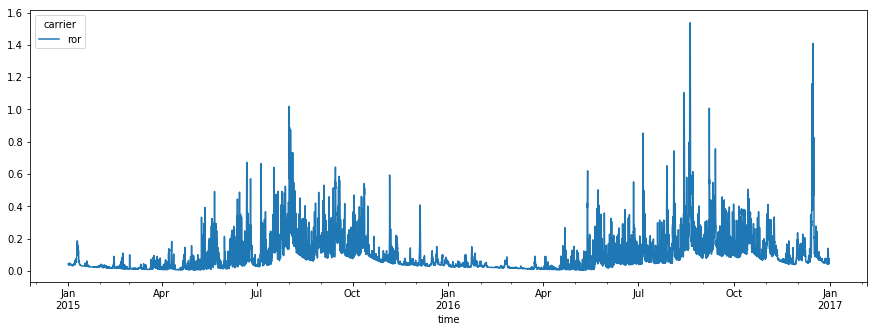

In [44]:
fig, ax = plt.subplots(figsize=(15,5))

n.generators_t.p_max_pu.groupby([n.generators.carrier], axis=1).mean().iloc[0:2*8760] \
              .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).drop(columns=['wind', 'solar']).plot(ax=ax)

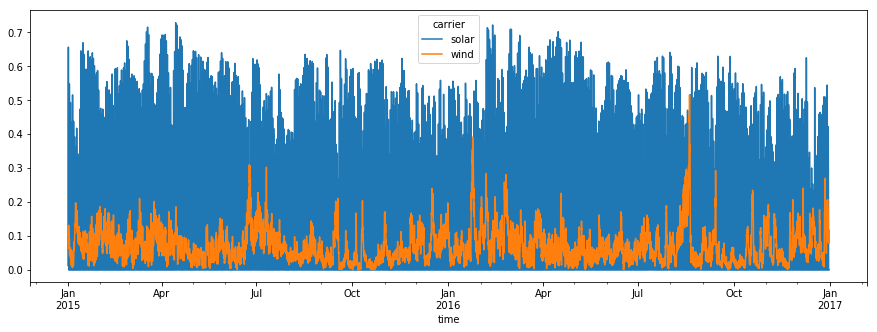

In [9]:
fig, ax = plt.subplots(figsize=(15,5))

n.generators_t.p_max_pu.groupby([n.generators.carrier], axis=1).mean().iloc[0:2*8760] \
              .rename(index=lambda x: x+pd.Timedelta(7, unit='h')).drop(columns=['ror']).plot(ax=ax)

In [ ]:
#add costs
costs = pd.read_csv('costs.csv', index_col=0)
n.generators['marginal_cost'] = n.generators.carrier.map(costs.marginal)
n.generators['capital_cost'] = n.generators.carrier.map(costs.capital)
n.generators['weight'] = 1 

#only assumptions, no resaerch done on this yet
n.carriers.loc['bioenergy', 'co2_emissions'] = 0.2
n.carriers.loc['hard coal', 'co2_emissions'] = 1.
#n.carriers.loc['bioenergy', 'co2_emissions'] = 0.2
#n.carriers.loc['bioenergy', 'co2_emissions'] = 0.2
n.generators.p_nom_extendable = True

n.export_to_netcdf('vietnam.nc')